## Imports and Reading Datasets

In [2]:
# !pip install --user uszipcode
# from uszipcode import SearchEngine
import pandas as pd
import numpy as np
import random

# search = SearchEngine(simple_zipcode=True)
# df = pd.read_csv('/datasets/iowaliquor.csv')[['Date', 'Store Name', 'Zip Code', 'Sale (Dollars)', 'County']]
# election_df = pd.read_csv('usa-2016-presidential-election-by-county.csv', sep=';')
# election_df = election_df[election_df['State'] == 'Iowa']

## Fill Missing Zip Codes

In [2]:
unqs = df[df["Zip Code"].isna()]["Store Name"].unique() # get unique store names
cities = [store.split("/")[-1].strip().lower() for store in unqs if "/" in store] # extract city name
if "mlk" in cities:
    cities.remove("mlk")
subset = df[df["Store Name"].str.contains("/") & (df["Zip Code"].isna())] 
city_dict = {}
for city in set(cities): # get zip code from rows with cities in store name
    city_dict[city] = search.by_city_and_state(city, "iowa")[0].zipcode
city_dict["mlk"] = '50310'
df.loc[subset.index, 'Zip Code'] = subset["Store Name"].str.split("/").str[-1].str.strip().str.lower().map(city_dict) 

## Aggregate and Get Zip Code Statistics

In [42]:
df["YearMonth"] = df["Date"].str.split("/").str[2] + "-" + df["Date"].str.split("/").str[0]

df = df[df["Zip Code"].notna()]
df["Zip Code"] = df["Zip Code"].replace("712-2", 51529)
df["Zip Code"] = df["Zip Code"].astype(int)

countyDict = {}
popDict = {}

for zc in df["Zip Code"].unique():
    stats = search.by_zipcode(zc)
    if stats.state == "IA":
        countyDict[zc] = stats.county
        popDict[zc] = stats.population

NameError: name 'df' is not defined

In [38]:
totalZip = pd.DataFrame(df.groupby(["YearMonth", "Zip Code"])["Sale (Dollars)"].sum())
totalZip.reset_index(inplace=True)
totalZip["Population"] = totalZip["Zip Code"].map(popDict)

## County Aggregate & Add Election Data

In [61]:
totalZip["County"] = totalZip["Zip Code"].map(countyDict)
totalZip.dropna(inplace=True)
totalCounty = pd.DataFrame(totalZip.groupby(["YearMonth", "County"])["Sale (Dollars)"].sum())
totalCounty.reset_index(inplace=True)
totalCounty["Month"] = totalCounty["YearMonth"].str.split("-").str[-1]

election_df["County"] = election_df["County"].str.replace(', Iowa', "")
totalCounty = totalCounty.merge(election_df, on="County")
totalCounty["SalesPerCapita"] = totalCounty["Sale (Dollars)"] / totalCounty["Total Population"]

## Unemployment Data

In [3]:
totalCounty = pd.read_csv("totalCounty.csv").drop("Unnamed: 0", axis=1)
totalCounty["Year"] = totalCounty["YearMonth"].str.split("-").str[0]
unemployment_df = pd.read_csv("iowa_unemployment.csv")
unemployment_df.rename(columns={"County Name": "County"}, inplace=True)
unemployment_df["Year"] = unemployment_df["Year"].astype(str)
unemployment_df["County"] = unemployment_df["County"] + " County"
totalCounty = pd.merge(totalCounty, unemployment_df,  how='left', left_on=['County','Year'], right_on = ['County','Year'])

## Transform Variables

In [6]:
totalCounty["LogSPC"] = np.log(totalCounty["SalesPerCapita"])
totalCounty["LogBachelors"] = np.log(totalCounty["At Least Bachelors's Degree"])
totalCounty["LogPop"] = np.log(totalCounty["Total Population"])
totalCounty["YearsPast2012"] = totalCounty["YearMonth"].str.split("-").str[0].astype(int) - 2012
totalCounty["Adult.smoking"] = totalCounty["Adult.smoking"].replace(np.nan, totalCounty["Adult.smoking"].mean())
totalCounty["BenefitsPerPerson"] = totalCounty["Benefits Paid"] / totalCounty["Total Population"]
totalCounty["Month"] = totalCounty["Month"].astype(str)
totalCounty["Intercept"] = 1
totalCounty["MedianAge*LogPop"] = totalCounty["Median Age"] * totalCounty["LogPop"]
totalCounty["MedianAge*Obesity"] = totalCounty["Median Age"] * totalCounty["Adult.obesity"]
totalCounty["MedianWage*Republicans2012"] = totalCounty["Median Earnings 2010"] * totalCounty["Republicans 2012"]
totalCounty["White*LogPop"] = totalCounty["White"] * totalCounty["LogPop"]
totalCounty["LogLatino"] = np.log(totalCounty["Latino Population"])
totalCounty["1/LogHomogeneity"] = 1 / np.log(totalCounty["Sire Homogeneity"])

## Linear Regression

In [42]:
cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "Diabetes", "White", "Less Than High School Diploma", "LogBachelors", "LogPop", "Median Earnings 2010", "YearsPast2012", "Adult.smoking", "Republicans 2012", "BenefitsPerPerson", "School Enrollment", "MedianAge*LogPop", "MedianAge*Obesity", "MedianWage*Republicans2012", "White*LogPop", "Service.occupations", "LogLatino", "1/LogHomogeneity"]
X = totalCounty[cols].dropna()
y = np.array(totalCounty['LogSPC'].loc[X.index])
X = pd.get_dummies(X, drop_first=True)
dummy_cols = X.columns
X = np.array(X)

b = np.linalg.inv(X.T@X)@X.T@y

np.sqrt(((np.e**y - np.e**(X@b))**2).mean())

2.4629486487646117

## Cross Validation

In [8]:
indices = [i for i in range(X.shape[0])]
group_size = X.shape[0] // 4
groups = []

for i in range(3):
    cur_group = random.sample(indices, group_size)
    groups.append(cur_group)
    for ind in cur_group:
        indices.remove(ind)
        
groups.append(indices)

In [9]:
scores = []
for i in range(4):
    train_inds = sum([groups[j] for j in range(len(groups)) if j != i], [])
    X_train = X[train_inds]
    X_test = X[groups[i]]
    y_train = y[train_inds]
    y_test = y[groups[i]]
    
    b = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
    scores.append(np.sqrt(((np.e**y_test - np.e**(X_test@b))**2).mean()))
    
np.mean(scores)

2.469144844691768

## AIC Score

In [10]:
def get_aic_score(X):
    indices = [i for i in range(X.shape[0])]
    group_size = X.shape[0] // 4
    groups = []

    for i in range(3):
        cur_group = random.sample(indices, group_size)
        groups.append(cur_group)
        for ind in cur_group:
            indices.remove(ind)

    groups.append(indices)

    aic_scores = []
    for i in range(4):
        train_inds = sum([groups[j] for j in range(len(groups)) if j != i], [])
        X_train = X[train_inds]
        X_test = X[groups[i]]
        y_train = y[train_inds]
        y_test = y[groups[i]]

        b = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
        residuals = np.e**y_test - np.e**(X_test@b)
        aic_scores.append((residuals**2).sum() / np.std(y_test)**2 + 2*X_train.shape[1])

    return np.mean(aic_scores)

get_aic_score(X)

33852.70587977362

## Calculate R^2

In [11]:
predictions = np.e**(X@b)
actual = np.e**y

ssTot = ((actual.mean() - actual)**2).sum()
ssRes = ((predictions - actual)**2).sum()

R2 = 1 - ssRes/ssTot
R2

0.48910169160323214

## Slope Confidence Intervals

In [12]:
bounds = []
t = 1.96
for i, col in enumerate(dummy_cols):
    var = X[:,i]
    se = np.sqrt(((predictions - actual)**2).sum() / (len(actual) - 2)) / np.sqrt(((var - var.mean())**2).sum())
    bounds.append((b[i] - se*t, b[i] + se*t))
    
ci_df = pd.DataFrame({"Variable": dummy_cols, "Bounds": bounds})

ci_df.head()

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


,Variable,Bounds
0,Intercept,"(-inf, inf)"
1,Median Age,"(-0.9215411814314183, -0.894178885542805)"
2,Adult.obesity,"(-42.17956263724854, -37.963297367191046)"
3,Diabetes,"(-1.0358944041359797, 8.642401181875996)"
4,White,"(0.11927524418839291, 0.13775920338877462)"


## Predicted vs. Actual Plot

In [13]:
res = pd.DataFrame({"Predictions": predictions, "Actual": actual})

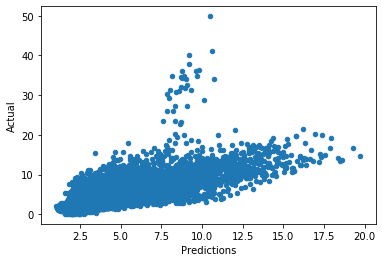

In [14]:
res.plot.scatter("Predictions", "Actual")

## Most Interpretable Model Selection

In [69]:
interpretable_cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "Diabetes", "White", "Less Than High School Diploma", "Median Earnings 2010", "YearsPast2012", "Adult.smoking", "Republicans 2012", "BenefitsPerPerson", "School Enrollment", "Service.occupations"]
subset = totalCounty[interpretable_cols + ["LogSPC"]].dropna()
done = False

while not done:
    aic_scores = []
    X = subset[interpretable_cols].dropna()
    y = np.array(subset['LogSPC'].loc[X.index])
    X = pd.get_dummies(X, drop_first=True)
    X = np.array(X)
    initial_aic = get_aic_score(X)
    print(initial_aic)
    for col in interpretable_cols: 
        X = subset[interpretable_cols].dropna().drop(col, axis=1)
        y = np.array(subset['LogSPC'].loc[X.index])
        X = pd.get_dummies(X, drop_first=True)
        X = np.array(X)
        aic_scores.append(get_aic_score(X))
    scores = pd.DataFrame({"Column": interpretable_cols, "AIC Score": aic_scores})
    if min(aic_scores) > initial_aic:
        done = True
    else:
        display(scores.sort_values("AIC Score"))
        removed_col = scores.sort_values("AIC Score")["Column"].iloc[0]
        print("Removed Column: ", removed_col)
        interpretable_cols.remove(removed_col)

48655.49838447785


,Column,AIC Score
7,Median Earnings 2010,45531.319736
2,Median Age,46782.175904
9,Adult.smoking,48170.262782
10,Republicans 2012,48173.862597
13,Service.occupations,48387.541352
4,Diabetes,48410.012437
3,Adult.obesity,48658.546748
12,School Enrollment,49650.900240
11,BenefitsPerPerson,50493.850296
1,Month,50855.591969


Removed Column:  Median Earnings 2010
45550.86921436318


,Column,AIC Score
2,Median Age,44941.781619
9,Republicans 2012,45098.073647
8,Adult.smoking,45292.713497
4,Diabetes,45447.010091
12,Service.occupations,45728.283693
3,Adult.obesity,46143.742564
10,BenefitsPerPerson,46435.316353
11,School Enrollment,47519.268510
7,YearsPast2012,47858.529578
1,Month,48186.403758


Removed Column:  Median Age
45172.28614985821


,Column,AIC Score
7,Adult.smoking,44821.654343
8,Republicans 2012,44859.321785
3,Diabetes,45187.701192
11,Service.occupations,45399.299673
2,Adult.obesity,45685.153035
9,BenefitsPerPerson,45947.587443
10,School Enrollment,47383.566728
6,YearsPast2012,47435.083015
1,Month,47903.731182
5,Less Than High School Diploma,53093.050789


Removed Column:  Adult.smoking
44817.9836300752


,Column,AIC Score
7,Republicans 2012,44682.720922
3,Diabetes,44803.643648
2,Adult.obesity,45486.161076
10,Service.occupations,45505.393916
8,BenefitsPerPerson,45690.812218
6,YearsPast2012,47300.071534
9,School Enrollment,47594.414043
1,Month,47603.067433
5,Less Than High School Diploma,52955.901631
4,White,53666.207014


Removed Column:  Republicans 2012
44584.5974409127


## Best Predictor Model Selection

In [16]:
def get_rmse(X, y):
    indices = [i for i in range(X.shape[0])]
    group_size = X.shape[0] // 4
    groups = []

    for i in range(3):
        cur_group = random.sample(indices, group_size)
        groups.append(cur_group)
        for ind in cur_group:
            indices.remove(ind)

    groups.append(indices)
    scores = []
    for i in range(4):
        train_inds = sum([groups[j] for j in range(len(groups)) if j != i], [])
        X_train = X[train_inds]
        X_test = X[groups[i]]
        y_train = y[train_inds]
        y_test = y[groups[i]]

        b = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
        scores.append(np.sqrt(((np.e**y_test - np.e**(X_test@b))**2).mean()))

    return np.mean(scores)

In [27]:
cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "Diabetes", "White", "Less Than High School Diploma", "LogBachelors", "LogPop", "Median Earnings 2010", "YearsPast2012", "Adult.smoking", "Republicans 2012", "BenefitsPerPerson", "School Enrollment", "MedianAge*LogPop", "MedianAge*Obesity", "MedianWage*Republicans2012", "White*LogPop", "Service.occupations", "LogLatino", "1/LogHomogeneity"]
cur_cols = ["Intercept"]

done = False

while not done:
    subset = totalCounty[cols + ["LogSPC"]].dropna()
    X = subset[cur_cols]
    y = np.array(subset['LogSPC'].loc[X.index])
    X = pd.get_dummies(X, drop_first=True)
    X = np.array(X)
    initial_rmse = get_rmse(X, y)
    rmses = []
    cols_left = []
    for col in cols:
        if col not in cur_cols:
            X = subset[cur_cols + [col]]
            y = np.array(subset['LogSPC'].loc[X.index])
            X = pd.get_dummies(X, drop_first=True)
            X = np.array(X)
            rmses.append(get_rmse(X, y))
            cols_left.append(col)
    rmses = pd.DataFrame({"Column": cols_left, "RMSE": rmses})
    display(rmses)
    if rmses["RMSE"].min() < initial_rmse:
        cur_cols.append(rmses.sort_values("RMSE")["Column"].iloc[0])
        print(rmses.sort_values("RMSE")["Column"].iloc[0], rmses["RMSE"].min())
    else:
        done = True

,Column,RMSE
0,Month,3.498708
1,Median Age,3.403532
2,Adult.obesity,3.459582
3,Diabetes,3.487226
4,White,3.405577
5,Less Than High School Diploma,3.493192
6,LogBachelors,3.210764
7,LogPop,2.998770
8,Median Earnings 2010,3.563708
9,YearsPast2012,3.519666


LogPop 2.9987701411563186


,Column,RMSE
0,Month,2.905204
1,Median Age,2.994885
2,Adult.obesity,2.992941
3,Diabetes,2.992968
4,White,2.992548
5,Less Than High School Diploma,2.990982
6,LogBachelors,2.982158
7,Median Earnings 2010,2.975055
8,YearsPast2012,2.939272
9,Adult.smoking,3.000473


Month 2.9052038674575646


,Column,RMSE
0,Median Age,2.910515
1,Adult.obesity,2.906678
2,Diabetes,2.907887
3,White,2.904875
4,Less Than High School Diploma,2.906480
5,LogBachelors,2.901220
6,Median Earnings 2010,2.891826
7,YearsPast2012,2.845114
8,Adult.smoking,2.912397
9,Republicans 2012,2.911099


YearsPast2012 2.8451137595377025


,Column,RMSE
0,Median Age,2.850565
1,Adult.obesity,2.849211
2,Diabetes,2.857139
3,White,2.847512
4,Less Than High School Diploma,2.849812
5,LogBachelors,2.839665
6,Median Earnings 2010,2.840989
7,Adult.smoking,2.855865
8,Republicans 2012,2.856477
9,BenefitsPerPerson,2.851590


Service.occupations 2.829291923783911


,Column,RMSE
0,Median Age,2.833668
1,Adult.obesity,2.834647
2,Diabetes,2.831905
3,White,2.821645
4,Less Than High School Diploma,2.832256
5,LogBachelors,2.820581
6,Median Earnings 2010,2.848375
7,Adult.smoking,2.834870
8,Republicans 2012,2.829557
9,BenefitsPerPerson,2.833612


LogBachelors 2.8205810380780805


,Column,RMSE
0,Median Age,2.773582
1,Adult.obesity,2.831044
2,Diabetes,2.812060
3,White,2.821469
4,Less Than High School Diploma,2.821602
5,Median Earnings 2010,2.865509
6,Adult.smoking,2.827603
7,Republicans 2012,2.816494
8,BenefitsPerPerson,2.812606
9,School Enrollment,2.786588


MedianAge*LogPop 2.750487905672479


,Column,RMSE
0,Median Age,2.729046
1,Adult.obesity,2.757052
2,Diabetes,2.750177
3,White,2.737478
4,Less Than High School Diploma,2.748469
5,Median Earnings 2010,2.645514
6,Adult.smoking,2.756317
7,Republicans 2012,2.749339
8,BenefitsPerPerson,2.749333
9,School Enrollment,2.721228


Median Earnings 2010 2.645513965217602


,Column,RMSE
0,Median Age,2.632560
1,Adult.obesity,2.643767
2,Diabetes,2.635287
3,White,2.636980
4,Less Than High School Diploma,2.638284
5,Adult.smoking,2.642763
6,Republicans 2012,2.607559
7,BenefitsPerPerson,2.644288
8,School Enrollment,2.590080
9,MedianAge*Obesity,2.643458


School Enrollment 2.5900796610662256


,Column,RMSE
0,Median Age,2.552886
1,Adult.obesity,2.593777
2,Diabetes,2.587506
3,White,2.599834
4,Less Than High School Diploma,2.592025
5,Adult.smoking,2.587944
6,Republicans 2012,2.564640
7,BenefitsPerPerson,2.597304
8,MedianAge*Obesity,2.587034
9,MedianWage*Republicans2012,2.562684


Median Age 2.5528856933894284


,Column,RMSE
0,Adult.obesity,2.535025
1,Diabetes,2.540569
2,White,2.558330
3,Less Than High School Diploma,2.549057
4,Adult.smoking,2.542253
5,Republicans 2012,2.526669
6,BenefitsPerPerson,2.568027
7,MedianAge*Obesity,2.535069
8,MedianWage*Republicans2012,2.526785
9,White*LogPop,2.564085


Republicans 2012 2.5266685818414216


,Column,RMSE
0,Adult.obesity,2.509614
1,Diabetes,2.518154
2,White,2.528586
3,Less Than High School Diploma,2.515154
4,Adult.smoking,2.527010
5,BenefitsPerPerson,2.542581
6,MedianAge*Obesity,2.513456
7,MedianWage*Republicans2012,2.523843
8,White*LogPop,2.525246
9,LogLatino,2.528688


Adult.obesity 2.5096144713955977


,Column,RMSE
0,Diabetes,2.512073
1,White,2.514168
2,Less Than High School Diploma,2.499498
3,Adult.smoking,2.513752
4,BenefitsPerPerson,2.527113
5,MedianAge*Obesity,2.500754
6,MedianWage*Republicans2012,2.498427
7,White*LogPop,2.512790
8,LogLatino,2.517462
9,1/LogHomogeneity,2.528834


MedianWage*Republicans2012 2.4984265679010935


,Column,RMSE
0,Diabetes,2.502004
1,White,2.503293
2,Less Than High School Diploma,2.496884
3,Adult.smoking,2.506233
4,BenefitsPerPerson,2.519961
5,MedianAge*Obesity,2.492911
6,White*LogPop,2.504337
7,LogLatino,2.509300
8,1/LogHomogeneity,2.523598


MedianAge*Obesity 2.4929107025278894


,Column,RMSE
0,Diabetes,2.494951
1,White,2.478435
2,Less Than High School Diploma,2.489283
3,Adult.smoking,2.492219
4,BenefitsPerPerson,2.506198
5,White*LogPop,2.481411
6,LogLatino,2.480668
7,1/LogHomogeneity,2.505322


White 2.4784345192053263


,Column,RMSE
0,Diabetes,2.483068
1,Less Than High School Diploma,2.470748
2,Adult.smoking,2.478490
3,BenefitsPerPerson,2.500899
4,White*LogPop,2.482216
5,LogLatino,2.486110
6,1/LogHomogeneity,2.486856


Less Than High School Diploma 2.4707481632251707


,Column,RMSE
0,Diabetes,2.473565
1,Adult.smoking,2.470672
2,BenefitsPerPerson,2.502005
3,White*LogPop,2.481500
4,LogLatino,2.477712
5,1/LogHomogeneity,2.461399


1/LogHomogeneity 2.461399077010095


,Column,RMSE
0,Diabetes,2.460312
1,Adult.smoking,2.453412
2,BenefitsPerPerson,2.486764
3,White*LogPop,2.478540
4,LogLatino,2.422159


LogLatino 2.422159005976689


,Column,RMSE
0,Diabetes,2.427893
1,Adult.smoking,2.422596
2,BenefitsPerPerson,2.443026
3,White*LogPop,2.441483


## Model Evaluation

In [71]:
interpretable_model_cols = ["Intercept", "Month", "Adult.obesity", "Diabetes", "White", "Less Than High School Diploma", "YearsPast2012", "BenefitsPerPerson", "School Enrollment", "Service.occupations"]

subset = totalCounty[interpretable_model_cols + ["LogSPC"]]
X = subset[interpretable_model_cols].dropna()
y = np.array(subset['LogSPC'].loc[X.index])
X = pd.get_dummies(X, drop_first=True)
X = np.array(X)

print(get_rmse(X, y))

b = np.linalg.inv(X.T@X)@X.T@y

predictions = np.e**(X@b)
actual = np.e**y

ssTot = ((actual.mean() - actual)**2).sum()
ssRes = ((predictions - actual)**2).sum()

R2 = 1 - ssRes/ssTot
R2

2.842964548958659


0.3196523564759549

In [66]:
best_model_cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "White", "Less Than High School Diploma", "LogBachelors", "LogPop", "Median Earnings 2010", "YearsPast2012", "Republicans 2012", "School Enrollment", "MedianAge*LogPop", "MedianAge*Obesity", "MedianWage*Republicans2012", "Service.occupations", "LogLatino", "1/LogHomogeneity"]

subset = totalCounty[best_model_cols + ["LogSPC"]]
X = subset[best_model_cols].dropna()
y = np.array(subset['LogSPC'].loc[X.index])
X = pd.get_dummies(X, drop_first=True)
X = np.array(X)

print(get_rmse(X, y))

b = np.linalg.inv(X.T@X)@X.T@y

predictions = np.e**(X@b)
actual = np.e**y

ssTot = ((actual.mean() - actual)**2).sum()
ssRes = ((predictions - actual)**2).sum()

R2 = 1 - ssRes/ssTot
R2

2.4532063358065597


0.5126983353835631

In [4]:
totalCounty

,YearMonth,County,Sale (Dollars),Month,State,ST,Fips,Precincts,Votes,Democrats 08 (Votes),...,Benefits Paid,Weeks Compensated,Recipients,First Payments,Final Payments,County FIP,GNIS Feature ID,Primary Lat Dec,Primary Long Dec,Primary County Coordinates
0,2012-01,Adair County,15988.30,1,Iowa,IA,19001,6.0,3759.0,1924.0,...,922248.0,2761.0,314.0,251.0,64.0,19001.0,465190.0,41.330746,-94.470941,POINT (-94.4709413 41.3307464)
1,2012-02,Adair County,17596.63,2,Iowa,IA,19001,6.0,3759.0,1924.0,...,922248.0,2761.0,314.0,251.0,64.0,19001.0,465190.0,41.330746,-94.470941,POINT (-94.4709413 41.3307464)
2,2012-03,Adair County,14380.75,3,Iowa,IA,19001,6.0,3759.0,1924.0,...,922248.0,2761.0,314.0,251.0,64.0,19001.0,465190.0,41.330746,-94.470941,POINT (-94.4709413 41.3307464)
3,2012-04,Adair County,18161.12,4,Iowa,IA,19001,6.0,3759.0,1924.0,...,922248.0,2761.0,314.0,251.0,64.0,19001.0,465190.0,41.330746,-94.470941,POINT (-94.4709413 41.3307464)
4,2012-05,Adair County,18881.41,5,Iowa,IA,19001,6.0,3759.0,1924.0,...,922248.0,2761.0,314.0,251.0,64.0,19001.0,465190.0,41.330746,-94.470941,POINT (-94.4709413 41.3307464)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10275,2020-04,Wright County,110384.60,4,Iowa,IA,19197,11.0,5949.0,3102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10276,2020-05,Wright County,71600.60,5,Iowa,IA,19197,11.0,5949.0,3102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10277,2020-06,Wright County,81209.23,6,Iowa,IA,19197,11.0,5949.0,3102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10278,2020-07,Wright County,70384.34,7,Iowa,IA,19197,11.0,5949.0,3102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
